In [1]:
# Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from sklearn import preprocessing
import textwrap
import seaborn as sns
import math

from imblearn.under_sampling import RandomUnderSampler 

import warnings
warnings.filterwarnings("ignore")

# TO-DO LIST
# 1. Recheck the H_a in RT scripts.

In [2]:
# Rename all the unnamed columns for consistency and easy data handeling
first_columns = ["Participant_ID", "RSVP", "TTS", "Trial_No"]

with open('Data/LanePositionDifference.csv') as f:
    lpd_num_cols = max(len(line.split(',')) for line in f)
with open('Data/BrakingInput.csv') as f:
    bi_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelAngles.csv') as f:
    swa_num_cols = max(len(line.split(',')) for line in f)
with open('Data/SteeringWheelVelocity.csv') as f:
    swv_num_cols = max(len(line.split(',')) for line in f)

# Extracting the driving performance metric data
rt_df = pd.read_csv("Data/ReactionTimes.csv")
lpd_df = pd.read_csv("Data/LanePositionDifference.csv", names=(first_columns + ["DP" + str(i) for i in range(0, lpd_num_cols - 4)]), skiprows = 1)
bi_df = pd.read_csv("Data/BrakingInput.csv", names=(first_columns + ["DP" + str(i) for i in range(0, bi_num_cols - 4)]), skiprows = 1)
swa_df = pd.read_csv("Data/SteeringWheelAngles.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swa_num_cols - 4)]), skiprows = 1)
swv_df = pd.read_csv("Data/SteeringWheelVelocity.csv", names=(first_columns + ["DP" + str(i) for i in range(0, swv_num_cols - 4)]), skiprows = 1)
scenario_df = pd.read_csv("Data/Scenario.csv")

# Extracting reading comprehension data
comp_test_df = pd.read_csv("Data/ComprehensionTest.csv")

# Extracting the survey data
# You must manually change the columns names in the NASA-TLX Form
nasa_tlx = pd.read_csv("Data/NASA_TLX.csv")
# pre_study = pd.read_csv("Data/Pre_Study.csv")
# post_study = pd.read_csv("Data/Post_Study.csv")



# Giving column names to all the tables that don't have a name.
rt_columns = first_columns + ["DP" + str(i) for i in range(0, rt_df.shape[1] - 4)]
rt_df.columns = rt_columns
scenario_columns = first_columns + ["DP" + str(i) for i in range(0, scenario_df.shape[1] - 4)]
scenario_df.columns = scenario_columns

In [51]:
# Utility Methods here
def is_outlier(data_point, q1, q3):
    IQR = q3 - q1
    return data_point < q1 - 1.5*IQR or data_point > q3 + 1.5*IQR

def get_stats(np_array):
    q1, q3 = np.percentile(np.sort(np_array), [25, 75])
    return (q1, q3)

def remove_outliers(df, column_name):
    q1_rsvp, q3_rsvp = get_stats(np.array(df[df["TPTAA"]=="RSVPNAA"][column_name].values))
    q1_rsvpa, q3_rsvpa = get_stats(np.array(df[df["TPTAA"]=="RSVPAA"][column_name].values))
    q1_stp, q3_stp = get_stats(np.array(df[df["TPTAA"]=="STPNAA"][column_name].values))
    q1_stpa, q3_stpa = get_stats(np.array(df[df["TPTAA"]=="STPAA"][column_name].values))
    index_list = []
    for i in range(0, df.shape[0]):
        if df.iloc[i]["TPTAA"] == "RSVPNAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvp, q3_rsvp):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "RSVPAA":
            if is_outlier(df.iloc[i][column_name], q1_rsvpa, q3_rsvpa):
                index_list.append(i)
        elif df.iloc[i]["TPTAA"] == "STPNAA":
            if is_outlier(df.iloc[i][column_name], q1_stp, q3_stp):
                index_list.append(i)
        elif is_outlier(df.iloc[i][column_name], q1_stpa, q3_stpa):
                index_list.append(i)
    df.drop(index_list, axis=0, inplace=True)
    df.reset_index(inplace=True)

def generate_refined(old_df, old_data_col, new_data_col):
    refined_df = pd.DataFrame(columns = ["Participant_ID", "TPT", "Audio Assistance", new_data_col])
    refined_df[new_data_col] = refined_df[new_data_col].astype(float)

    for participant in old_df["Participant_ID"].unique():
        p_data = old_df[(old_df["Participant_ID"] == participant)]
        # Inserting data of the first trial
        try:
            new_arr_1 = [participant, "RSVP", "NAA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_1
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_2 = [participant, "RSVP", "AA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_2
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_3 = [participant, "STP", "NAA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_3
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_4 = [participant, "STP", "AA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)][old_data_col].values[0]]
            refined_df.loc[len(refined_df)] = new_arr_4
        except:
            print("WARNING: Data point missing")

        # Inserting data of the second trial
        try:
            new_arr_1 = [participant, "RSVP", "NAA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 0)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_1
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_2 = [participant, "RSVP", "AA", p_data[(p_data["RSVP"] == 1) & (p_data["TTS"] == 1)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_2
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_3 = [participant, "STP", "NAA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 0)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_3
        except:
            print("WARNING: Data point missing")
        try:
            new_arr_4 = [participant, "STP", "AA", p_data[(p_data["RSVP"] == 0) & (p_data["TTS"] == 1)][old_data_col].values[1]]
            refined_df.loc[len(refined_df)] = new_arr_4
        except:
            print("WARNING: Data point missing")
    return refined_df

def under_sampling(df, data_col):
    rus = RandomUnderSampler(random_state=50)
    df_c2, df_c1 = rus.fit_resample(df[data_col].values.reshape((-1, 1)), df["TPTAA"].astype(str))
    new_df = pd.DataFrame()
    new_df["TPTAA"] = df_c1
    new_df[data_col] = df_c2.astype(float)
    return new_df
def create_seperate_arrays(df, data_col):
    rt_stp = df[df["TPTAA"] == "STPNAA"][data_col].values
    rt_stpa = df[df["TPTAA"] == "STPAA"][data_col].values
    rt_rsvp = df[df["TPTAA"] == "RSVPNAA"][data_col].values
    rt_rsvpa = df[df["TPTAA"] == "RSVPAA"][data_col].values
    return (rt_stp, rt_stpa, rt_rsvp, rt_rsvpa)

def plot_driving_metric(df, data_col):
        df_decoupled = decouple_df(df)
        plot = sns.barplot(data=df_decoupled, x="Text Presentation Technique", y=data_col, hue="Audio Assistance", capsize=0.1)
        for p in plot.containers:
            plot.bar_label(p, fmt='%.3f', label_type='center')

def decouple_df(df):
    # This method also renames the values of "Audio Assistance" Column
    new_df = pd.DataFrame(columns=["Text Presentation Technique", "Audio Assistance", list(df.columns)[1]])
    for index, row in df.iterrows():
        new_row = []
        if "RSVP" in row["TPTAA"]:
            new_row.append("RSVP")
        else:
            new_row.append("STP")
            
        if "NAA" in row["TPTAA"]:
            new_row.append("Audio Assistance Disabled")
        else:
            new_row.append("Audio Assistance Enabled")
        new_row.append(row[df.columns[1]])
        new_df = new_df.append({'Text Presentation Technique': new_row[0], 'Audio Assistance': new_row[1], list(df.columns)[1]: new_row[2]}, ignore_index=True)
    new_df[df.columns[1]] = new_df[df.columns[1]].astype(float)
    new_df.sort_values(['Text Presentation Technique', 'Audio Assistance'], ascending=[False, True], inplace=True)
    return new_df

In [52]:
exclusion = ['P01', 'P02', 'P03', 'P04', 'P05', 'P09']

# Excluding certain participants' driving performance
for participant in exclusion:
    rt_df = rt_df[rt_df["Participant_ID"] != participant]
    lpd_df = lpd_df[lpd_df["Participant_ID"] != participant]
    bi_df = bi_df[bi_df["Participant_ID"] != participant]
    swa_df = swa_df[swa_df["Participant_ID"] != participant]
    swv_df = swv_df[swv_df["Participant_ID"] != participant]

# Excluding certain participants' reading comprehension performance
for participant in exclusion:
    comp_test_df = comp_test_df[comp_test_df["Q1"] != participant]
    
# Exclusing certain participants' subjective surveys
for participant in exclusion:
    nasa_tlx = nasa_tlx[nasa_tlx["Q1"] != participant]
#     pre_study = pre_study[pre_study["ID"] != participant]
#     post_study = post_study[post_study["Q1"] != participant]

# TODO: Write code to remove the data point of Major collisions.

Shapiro Test for RT_stp; p-value:  0.3799164891242981
Shapiro Test for RT_rsvp; p-value:  0.5792020559310913
Shapiro Test for RT_stpa; p-value:  0.9671230316162109
Shapiro Test for RT_rsvpa; p-value:  0.2043161541223526
H_0: RT_rsvp = RT_stp ; H_a: RT_rsvp < RT_stp
Ttest_relResult(statistic=0.6433991839178619, pvalue=0.7382261298758739)
H_0: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa < RT_stpa
Ttest_relResult(statistic=-1.4482486705746735, pvalue=0.07757614447465713)
H_0: RT_rsvpa = RT_rsvp ; H_a: RT_rsvpa < RT_rsvp
Ttest_relResult(statistic=-1.117497519638947, pvalue=0.13514367879224795)
H_0: RT_stpa = RT_stp ; H_a: RT_stpa < RT_stp
Ttest_relResult(statistic=1.621415065215106, pvalue=0.9437025026958938)
H_0: RT_rsvp = RT_stp ; H_a: RT_rsvp > RT_stp
Ttest_relResult(statistic=0.6433991839178619, pvalue=0.2617738701241261)
H_0: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa > RT_stpa
Ttest_relResult(statistic=-1.4482486705746735, pvalue=0.9224238555253429)
H_0: RT_rsvpa = RT_rsvp ; H_a: RT_rsvpa > RT_rsvp
T

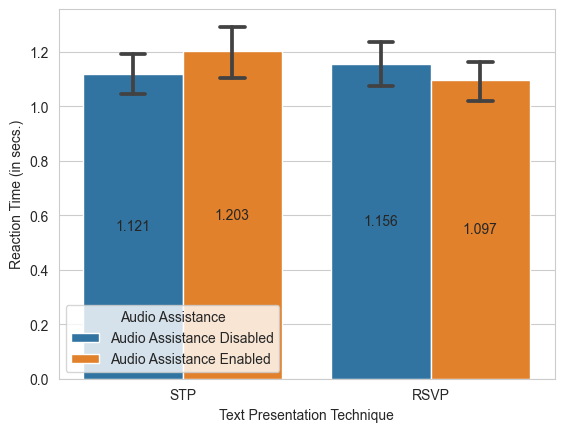

In [53]:
# Restructuring the data frame.
rt_refined = generate_refined(rt_df, "DP0", "RT")

# Combine columns TPT and Audio Assistance
rt_combined = pd.DataFrame()
rt_combined["TPTAA"] = rt_refined["TPT"].values + rt_refined["Audio Assistance"].values
rt_combined["Reaction Time (in secs.)"] = rt_refined["RT"].values
# Removing the outliers from the data frame
remove_outliers(rt_combined, "Reaction Time (in secs.)")

# Under sampling the data set
rt_combined = under_sampling(rt_combined, "Reaction Time (in secs.)")

# Creating sperate arrays for analysis
rt_stp, rt_stpa, rt_rsvp, rt_rsvpa = create_seperate_arrays(rt_combined, "Reaction Time (in secs.)")

# Test if the distribution is normal.
print("Shapiro Test for RT_stp; p-value: ", stats.shapiro(rt_stp)[1])
print("Shapiro Test for RT_rsvp; p-value: ", stats.shapiro(rt_rsvp)[1])
print("Shapiro Test for RT_stpa; p-value: ", stats.shapiro(rt_stpa)[1])
print("Shapiro Test for RT_rsvpa; p-value: ", stats.shapiro(rt_rsvpa)[1])

# Perform P-tests for testing the alternate hypothesis
# Test if H_a: RT_rsvp < RT_stp
print("H_0: RT_rsvp = RT_stp ; H_a: RT_rsvp < RT_stp")
print(stats.ttest_rel(a = rt_rsvp, b = rt_stp, alternative = "less"))
print("H_0: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa < RT_stpa")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_stpa, alternative = "less"))
# Test if H_a: RT_aae < RT_aad
print("H_0: RT_rsvpa = RT_rsvp ; H_a: RT_rsvpa < RT_rsvp")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_rsvp, alternative = "less"))
print("H_0: RT_stpa = RT_stp ; H_a: RT_stpa < RT_stp")
print(stats.ttest_rel(a = rt_stpa, b = rt_stp, alternative = "less"))

# Test if H_a: RT_rsvp > RT_stp
print("H_0: RT_rsvp = RT_stp ; H_a: RT_rsvp > RT_stp")
print(stats.ttest_rel(a = rt_rsvp, b = rt_stp, alternative = "greater"))
print("H_0: RT_rsvpa = RT_stpa ; H_a: RT_rsvpa > RT_stpa")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_stpa, alternative = "greater"))
# Test if H_a: RT_aae > RT_aad
print("H_0: RT_rsvpa = RT_rsvp ; H_a: RT_rsvpa > RT_rsvp")
print(stats.ttest_rel(a = rt_rsvpa, b = rt_rsvp, alternative = "greater"))
print("H_0: RT_stpa = RT_stp ; H_a: RT_stpa > RT_stp")
print(stats.ttest_rel(a = rt_stpa, b = rt_stp, alternative = "greater"))

# plot graph
plot_driving_metric(rt_combined, "Reaction Time (in secs.)")

Shapiro Test for alpo_stp; p-value: 0.8130557537078857
Shapiro Test for alpo_rsvp; p-value: 0.08807837218046188
Shapiro Test for alpo_stpa; p-value: 0.0017737220041453838
Shapiro Test for alpo_rsvpa; p-value: 0.7044598460197449 

H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp < alpo_stp
Ttest_relResult(statistic=0.2067214574950561, pvalue=0.5813984108206556)
H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa < alpo_stpa
Ttest_relResult(statistic=1.0010587892490024, pvalue=0.838800665741984)
H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa < alpo_rsvp
Ttest_relResult(statistic=1.8738752953811335, pvalue=0.9661234147871273)
H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa < alpo_stp
Ttest_relResult(statistic=0.7993085497895626, pvalue=0.7857475645567831)
H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp > alpo_stp
Ttest_relResult(statistic=0.2067214574950561, pvalue=0.4186015891793444)
H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa > alpo_stpa
Ttest_relResult(statistic=1.0010587892490024, pvalue=0.161199334258015

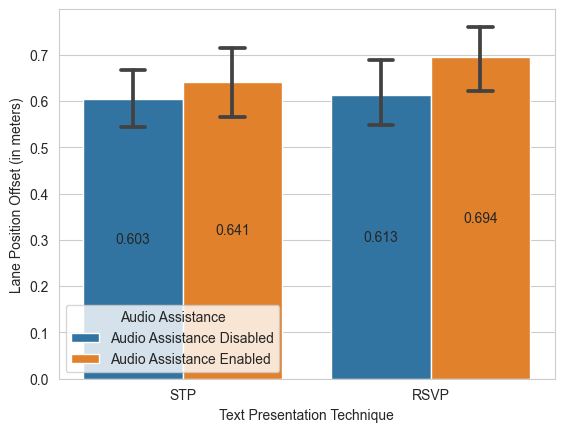

In [54]:
# Analyzing the Average Lane Position Offset.
avg_lane_offsets = []
for i in range(0, lpd_df.shape[0]):
    dp_array = [dp for dp in lpd_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    avg_lane_offsets.append(sum(dp_array)/len(dp_array))
lpd_df["AVG"] = avg_lane_offsets

# Restructuring the data frame.
lpd_refined = generate_refined(lpd_df, "AVG", "LPO")

# Combine columns TPT and Audio Assistance
lpd_combined = pd.DataFrame()
lpd_combined["TPTAA"] = lpd_refined["TPT"].values + lpd_refined["Audio Assistance"].values
lpd_combined["Lane Position Offset (in meters)"] = lpd_refined["LPO"].values

# Removing the outliers from the data frame
remove_outliers(lpd_combined, "Lane Position Offset (in meters)")

# Under sampling the data set
lpd_combined = under_sampling(lpd_combined, "Lane Position Offset (in meters)")

# Creating separate arrays for analysis
alpo_stp, alpo_stpa, alpo_rsvp, alpo_rsvpa = create_seperate_arrays(lpd_combined, "Lane Position Offset (in meters)")

# Test is the distribution is normal.
print("Shapiro Test for alpo_stp; p-value:", stats.shapiro(alpo_stp)[1])
print("Shapiro Test for alpo_rsvp; p-value:", stats.shapiro(alpo_rsvp)[1])
print("Shapiro Test for alpo_stpa; p-value:", stats.shapiro(alpo_stpa)[1])
print("Shapiro Test for alpo_rsvpa; p-value:", stats.shapiro(alpo_rsvpa)[1], "\n")

# Perform P-tests for testing the hypothesis
# Test if H_a: alpo_rsvp < alpo
print("H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp < alpo_stp")
print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "less"))
print("H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa < alpo_stpa")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "less"))
# Test if H_a: alpo_aae < alpo_aad
print("H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa < alpo_rsvp")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "less"))
print("H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa < alpo_stp")
print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "less"))

# Test if H_a: alpo_rsvp > alpo_stp
print("H_0: alpo_rsvp = alpo_stp ; H_a: alpo_rsvp > alpo_stp")
print(stats.ttest_rel(a = alpo_rsvp, b = alpo_stp, alternative = "greater"))
print("H_0: alpo_rsvpa = alpo_stpa ; H_a: alpo_rsvpa > alpo_stpa")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_stpa, alternative = "greater"))
# Test if H_a: alpo_aae > alpo_aad
print("H_0: alpo_rsvpa = alpo_rsvp ; H_a: alpo_rsvpa > alpo_rsvp")
print(stats.ttest_rel(a = alpo_rsvpa, b = alpo_rsvp, alternative = "greater"))
print("H_0: alpo_stpa = alpo_stp ; H_a: alpo_stpa > alpo_stp")
print(stats.ttest_rel(a = alpo_stpa, b = alpo_stp, alternative = "greater"))

# Getting decoupled dataframe for the graph
plot_driving_metric(lpd_combined, "Lane Position Offset (in meters)")

Shapiro Test for msav_stp; p-value: 0.18520303070545197
Shapiro Test for msav_rsvp; p-value: 0.044869620352983475
Shapiro Test for msav_stpa; p-value: 0.00046021389425732195
Shapiro Test for msav_rsvpa; p-value: 0.0019426248036324978 

H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp < msav_stp
Ttest_relResult(statistic=-0.895771404259602, pvalue=0.18774016831796464)
H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa < msav_stpa
Ttest_relResult(statistic=-1.7415091241050857, pvalue=0.044457607392033645)
H_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa < msav_rsvp
Ttest_relResult(statistic=-0.35987381194130613, pvalue=0.3603724210966719)
H_0: msav_stpa = msav_stp ; H_a: msav_stpa < msav_stp
Ttest_relResult(statistic=0.7345055847426376, pvalue=0.7666390404621422)
H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp > msav_stp
Ttest_relResult(statistic=-0.895771404259602, pvalue=0.8122598316820353)
H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa > msav_stpa
Ttest_relResult(statistic=-1.7415091241050857, pvalue=0.9

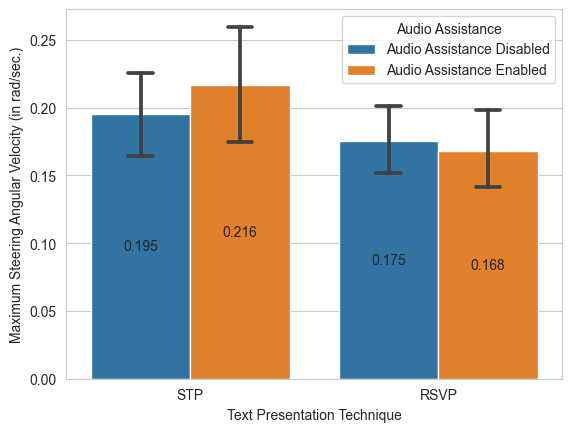

In [55]:
# Analyzing the Maximum Steering Angle Velocity
MSVs = []
for i in range(0, swv_df.shape[0]):
    dp_array = [dp for dp in swv_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MSVs.append(max(dp_array))
swv_df["MAX"] = MSVs

# Restructuring the data frame.
msav_refined = generate_refined(swv_df, "MAX", "MSAV")

# Combine columns TPT and Audio Assistance
msav_combined = pd.DataFrame()
msav_combined["TPTAA"] = msav_refined["TPT"].values + msav_refined["Audio Assistance"].values
msav_combined["Maximum Steering Angular Velocity (in rad/sec.)"] = msav_refined["MSAV"].values

# Removing the outliers from the data frame
remove_outliers(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Under sampling the data set
msav_combined = under_sampling(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Creating separate arrays for analysis
msav_stp, msav_stpa, msav_rsvp, msav_rsvpa = create_seperate_arrays(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for msav_stp; p-value:", stats.shapiro(msav_stp)[1])
print("Shapiro Test for msav_rsvp; p-value:", stats.shapiro(msav_rsvp)[1])
print("Shapiro Test for msav_stpa; p-value:", stats.shapiro(msav_stpa)[1])
print("Shapiro Test for msav_rsvpa; p-value:", stats.shapiro(msav_rsvpa)[1], "\n")

# Perform P-tests for testing the alternate hypothesis
# Test if H_a: msav_rsvp < msav_stp
print("H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp < msav_stp")
print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "less"))
print("H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa < msav_stpa")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "less"))
# Test if H_a: msav_aae < msav_aad
print("H_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa < msav_rsvp")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "less"))
print("H_0: msav_stpa = msav_stp ; H_a: msav_stpa < msav_stp")
print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "less"))

# Test if H_a: msav_rsvp > msav_stp
print("H_0: msav_rsvp = msav_stp ; H_a: msav_rsvp > msav_stp")
print(stats.ttest_rel(a = msav_rsvp, b = msav_stp, alternative = "greater"))
print("H_0: msav_rsvpa = msav_stpa ; H_a: msav_rsvpa > msav_stpa")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_stpa, alternative = "greater"))
# Test if H_a: msav_aae > msav_aad
print("H_0: msav_rsvpa = msav_rsvp ; H_a: msav_rsvpa > msav_rsvp")
print(stats.ttest_rel(a = msav_rsvpa, b = msav_rsvp, alternative = "greater"))
print("H_0: msav_stpa = msav_stp ; H_a: msav_stpa > msav_stp")
print(stats.ttest_rel(a = msav_stpa, b = msav_stp, alternative = "greater"))

# Getting decoupled dataframe for the graph
plot_driving_metric(msav_combined, "Maximum Steering Angular Velocity (in rad/sec.)")

Shapiro Test for sdswa_stp; p-value: 0.1639007180929184
Shapiro Test for sdswa_rsvp; p-value: 0.0004751942469738424
Shapiro Test for sdswa_stpa; p-value: 0.0013034010771661997
Shapiro Test for sdswa_rsvpa; p-value: 0.011535831727087498 

Test: SDSWA_rsvp < SDSWA_stp [p value: 0.8454782635369765]
Test: SDSWA_rsvpa < SDSWA_stpa [p value: 0.9968000836773573]
Test: SDSWA_rsvpa < SDSWA_rsvp [p value: 0.9542819492143424]
Test: SDSWA_stpa < SDSWA_stp [p value: 0.2889547751270013]
Test: SDSWA_rsvp > SDSWA_stp [p value: 0.15452173646302347]
Test: SDSWA_rsvpa > SDSWA_stpa [p value: 0.00329098589098712]
Test: SDSWA_rsvpa > SDSWA_rsvp [p value: 0.046615361458396926]
Test: SDSWA_stpa > SDSWA_stp [p value: 0.7142061700483644]


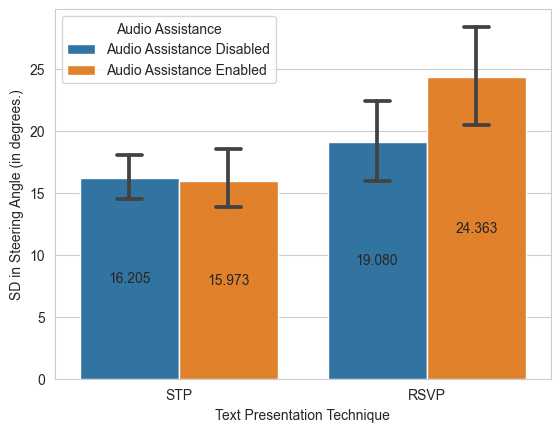

In [58]:
# Analyzing the Standard Deviation of Steering Wheel Angle
SDSWAs = []
for i in range(0, swa_df.shape[0]):
    dp_array = [dp for dp in swa_df.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    SDSWAs.append(np.std(dp_array))
swa_df["SD"] = SDSWAs

# Restructuring the data frame.
sdswa_refined = generate_refined(swa_df, "SD", "SDSWA")

# Combine columns TPT and Audio Assistance
sdswa_combined = pd.DataFrame()
sdswa_combined["TPTAA"] = sdswa_refined["TPT"].values + sdswa_refined["Audio Assistance"].values
sdswa_combined["SD in Steering Angle (in degrees.)"] = sdswa_refined["SDSWA"].values

# Removing the outliers from the data frame
remove_outliers(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Under sampling the data set
sdswa_combined = under_sampling(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Create separate arrays for 2 x 2 cases
sdswa_stp, sdswa_stpa, sdswa_rsvp, sdswa_rsvpa = create_seperate_arrays(sdswa_combined, "SD in Steering Angle (in degrees.)")

# Perform P-tests foer texting the hypothesis
print("Shapiro Test for sdswa_stp; p-value:", stats.shapiro(sdswa_stp)[1])
print("Shapiro Test for sdswa_rsvp; p-value:", stats.shapiro(sdswa_rsvp)[1])
print("Shapiro Test for sdswa_stpa; p-value:", stats.shapiro(sdswa_stpa)[1])
print("Shapiro Test for sdswa_rsvpa; p-value:", stats.shapiro(sdswa_rsvpa)[1], "\n")

# Perform Mann Whitney U test
stat1, p1 = wilcoxon(sdswa_rsvp, sdswa_stp, alternative='less')
print("Test: SDSWA_rsvp < SDSWA_stp [p value: {}]".format(p1))
stat2, p2 = mannwhitneyu(sdswa_rsvpa, sdswa_stpa, alternative='less')
print("Test: SDSWA_rsvpa < SDSWA_stpa [p value: {}]".format(p2))
stat3, p3 = mannwhitneyu(sdswa_rsvpa, sdswa_rsvp, alternative='less')
print("Test: SDSWA_rsvpa < SDSWA_rsvp [p value: {}]".format(p3))
stat4, p4 = mannwhitneyu(sdswa_stpa, sdswa_stp, alternative='less')
print("Test: SDSWA_stpa < SDSWA_stp [p value: {}]".format(p4))

stat5, p5 = wilcoxon(sdswa_rsvp, sdswa_stp, alternative='greater')
print("Test: SDSWA_rsvp > SDSWA_stp [p value: {}]".format(p5))
stat6, p6 = mannwhitneyu(sdswa_rsvpa, sdswa_stpa, alternative='greater')
print("Test: SDSWA_rsvpa > SDSWA_stpa [p value: {}]".format(p6))
stat7, p7 = mannwhitneyu(sdswa_rsvpa, sdswa_rsvp, alternative='greater')
print("Test: SDSWA_rsvpa > SDSWA_rsvp [p value: {}]".format(p7))
stat8, p8 = mannwhitneyu(sdswa_stpa, sdswa_stp, alternative='greater')
print("Test: SDSWA_stpa > SDSWA_stp [p value: {}]".format(p8))

# plot graph
plot_driving_metric(sdswa_combined, "SD in Steering Angle (in degrees.)")

Shapiro Test for BIR_stp; p-value:  0.25042665004730225
Shapiro Test for BIR_rsvp; p-value:  0.028921768069267273
Shapiro Test for BIR_stpa; p-value:  0.27472686767578125
Shapiro Test for BIR_rsvpa; p-value:  0.049716394394636154
Test: BIR_rsvp < BIR_stp [p value: 0.4775647581157356]
Test: BIR_rsvpa < BIR_stpa [p value: 0.9652882413325573]
Test: BIR_rsvpa < BIR_rsvp [p value: 0.6107624067961892]
Test: BIR_stpa < BIR_stp [p value: 0.08206062904306949]
Test: BIR_rsvp > BIR_stp [p value: 0.5224352418842644]
Test: BIR_rsvpa > BIR_stpa [p value: 0.03538054039647687]
Test: BIR_rsvpa > BIR_rsvp [p value: 0.3925607172208345]
Test: BIR_stpa > BIR_stp [p value: 0.919241167765086]


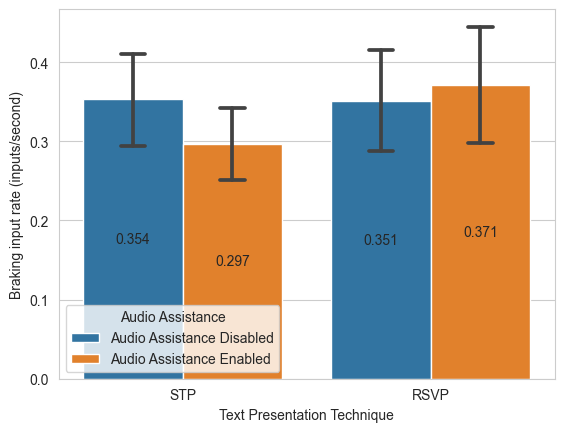

In [60]:
# Analysing the Breaking Input Rate

# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
BIRs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    count = 0
    for value in dp_array:
        if value != 0:
            count += 1
    rate = float(count)/len(dp_array)
    BIRs.append(rate)
bi_df_copy["RATE"] = BIRs

# Restructuring the data frame.
bir_refined = generate_refined(bi_df_copy, "RATE", "RATE")

# Combine columns TPT and Audio Assistance
bir_combined = pd.DataFrame()
bir_combined["TPTAA"] = bir_refined["TPT"].values + bir_refined["Audio Assistance"].values
bir_combined["Braking input rate (inputs/second)"] = bir_refined["RATE"].values

# Removing the outliers from the data frame
remove_outliers(bir_combined, "Braking input rate (inputs/second)")

# Under sampling the data set
bir_combined = under_sampling(bir_combined, "Braking input rate (inputs/second)")

# Create separate arrays for 2 x 2 cases
bir_stp, bir_stpa, bir_rsvp, bir_rsvpa = create_seperate_arrays(bir_combined, "Braking input rate (inputs/second)")

# Test if the distribution is normal.
print("Shapiro Test for BIR_stp; p-value: ", stats.shapiro(bir_stp)[1])
print("Shapiro Test for BIR_rsvp; p-value: ", stats.shapiro(bir_rsvp)[1])
print("Shapiro Test for BIR_stpa; p-value: ", stats.shapiro(bir_stpa)[1])
print("Shapiro Test for BIR_rsvpa; p-value: ", stats.shapiro(bir_rsvpa)[1])

# Perform Mann Whitney U test
stat1, p1 = wilcoxon(bir_rsvp, bir_stp, alternative='less')
print("Test: BIR_rsvp < BIR_stp [p value: {}]".format(p1))
stat2, p2 = mannwhitneyu(bir_rsvpa, bir_stpa, alternative='less')
print("Test: BIR_rsvpa < BIR_stpa [p value: {}]".format(p2))
stat3, p3 = mannwhitneyu(bir_rsvpa, bir_rsvp, alternative='less')
print("Test: BIR_rsvpa < BIR_rsvp [p value: {}]".format(p3))
stat4, p4 = mannwhitneyu(bir_stpa, bir_stp, alternative='less')
print("Test: BIR_stpa < BIR_stp [p value: {}]".format(p4))

stat5, p5 = wilcoxon(bir_rsvp, bir_stp, alternative='greater')
print("Test: BIR_rsvp > BIR_stp [p value: {}]".format(p5))
stat6, p6 = mannwhitneyu(bir_rsvpa, bir_stpa, alternative='greater')
print("Test: BIR_rsvpa > BIR_stpa [p value: {}]".format(p6))
stat7, p7 = mannwhitneyu(bir_rsvpa, bir_rsvp, alternative='greater')
print("Test: BIR_rsvpa > BIR_rsvp [p value: {}]".format(p7))
stat8, p8 = mannwhitneyu(bir_stpa, bir_stp, alternative='greater')
print("Test: BIR_stpa > BIR_stp [p value: {}]".format(p8))

# plot graph
plot_driving_metric(bir_combined, "Braking input rate (inputs/second)")

    TPT         AA Disabled           AA Enabled
0   STP  0.4480192487257898   0.3929536651992154
1  RSVP  0.4145339122976609  0.42748646087384534
Shapiro Test for MBI_stp; p-value:  0.14187845587730408
Shapiro Test for MBI_rsvp; p-value:  0.01479355338960886
Shapiro Test for MBI_stpa; p-value:  0.3862641155719757
Shapiro Test for MBI_rsvpa; p-value:  0.02170553430914879
Test: MBI_rsvp < MBI_stp [p value: 0.2306913039370272]
Test: MBI_rsvpa < MBI_stpa [p value: 0.8318743179259549]
Test: MBI_rsvpa < MBI_rsvp [p value: 0.6303121800835777]
Test: MBI_stpa < MBI_stp [p value: 0.11368032285470064]


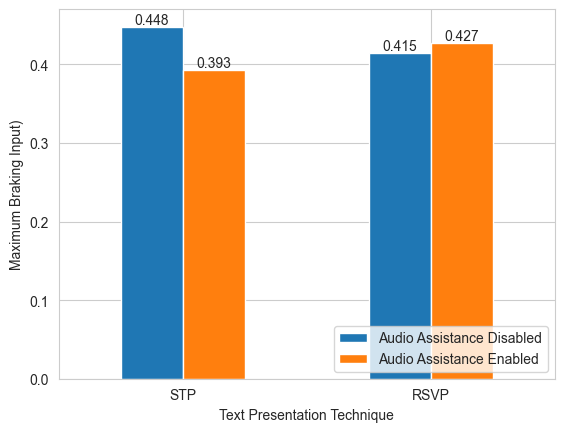

In [17]:
# Analysing the Maximum breaking input

# Creating a duplicate df to retain original data, and calculating rate
bi_df_copy = bi_df.copy()
MBIs = []
for i in range(0, bi_df_copy.shape[0]):
    dp_array = [dp for dp in bi_df_copy.iloc[i].values.tolist()[4:] if not pd.isna(dp)]
    MBIs.append(max(dp_array))
bi_df_copy["MAX"] = MBIs

# Create seperate arrays for 2 x 2 cases
mbi_stp = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_stpa = bi_df[(bi_df["RSVP"] == 0) & (bi_df["TTS"] == 1)]["MAX"].values
mbi_rsvp = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 0)]["MAX"].values
mbi_rsvpa = bi_df[(bi_df["RSVP"] == 1) & (bi_df["TTS"] == 1)]["MAX"].values

mbi_results_array = np.array([
    ["STP",np.mean(mbi_stp), np.mean(mbi_stpa)],
    ["RSVP",np.mean(mbi_rsvp), np.mean(mbi_rsvpa)],
])

mbi_results_df = pd.DataFrame(mbi_results_array, columns = ["TPT", "AA Disabled", "AA Enabled"])
print(mbi_results_df)

# Converting the column types
mbi_results_df["TPT"] = mbi_results_df["TPT"].astype(str)
mbi_results_df["AA Disabled"] = mbi_results_df["AA Disabled"].astype(float)
mbi_results_df["AA Enabled"] = mbi_results_df["AA Enabled"].astype(float)


# Test if the distribution is normal.
print("Shapiro Test for MBI_stp; p-value: ", stats.shapiro(mbi_stp)[1])
print("Shapiro Test for MBI_rsvp; p-value: ", stats.shapiro(mbi_rsvp)[1])
print("Shapiro Test for MBI_stpa; p-value: ", stats.shapiro(mbi_stpa)[1])
print("Shapiro Test for MBI_rsvpa; p-value: ", stats.shapiro(mbi_rsvpa)[1])

data_is_normal = False

if (data_is_normal):
    # Perform P-tests for testing the alternate hypothesis
    # Test if H_a: MBI_rsvp < MBI_stp
    print("H_a: MBI_rsvp = MBI_stp ; H_a: MBI_rsvp < MBI_stp")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_stp, alternative = "less"))
    print("H_a: MBI_rsvpa = MBI_stpa ; H_a: MBI_rsvpa < MBI_stpa")
    print(stats.ttest_rel(a = mbi_rsvpa, b = mbi_stpa, alternative = "less"))

    # Test if H_a: MBI_aae < MBI_aad
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for RSVP")
    print(stats.ttest_rel(a = mbi_rsvp, b = mbi_rsvpa, alternative = "less"))
    print("H_a: MBI_aae = MBI_aad ; H_a: MBI_aae < MBI_aad for STP")
    print(stats.ttest_rel(a = mbi_stp, b = mbi_stpa, alternative = "less"))
else:
    # Perform Mann Whitney U test
    stat1, p1 = wilcoxon(mbi_rsvp, mbi_stp, alternative='less')
    print("Test: MBI_rsvp < MBI_stp [p value: {}]".format(p1))
    
    stat2, p2 = mannwhitneyu(mbi_rsvpa, mbi_stpa, alternative='less')
    print("Test: MBI_rsvpa < MBI_stpa [p value: {}]".format(p2))
    
    stat3, p3 = mannwhitneyu(mbi_rsvpa, mbi_rsvp, alternative='less')
    print("Test: MBI_rsvpa < MBI_rsvp [p value: {}]".format(p3))
    
    stat4, p4 = mannwhitneyu(mbi_stpa, mbi_stp, alternative='less')
    print("Test: MBI_stpa < MBI_stp [p value: {}]".format(p4))

bplot = mbi_results_df.plot(x = "TPT", kind = "bar", rot = 0)
bplot.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"], loc="lower right")
plt.xlabel("Text Presentation Technique")
plt.ylabel("Maximum Braking Input)")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')

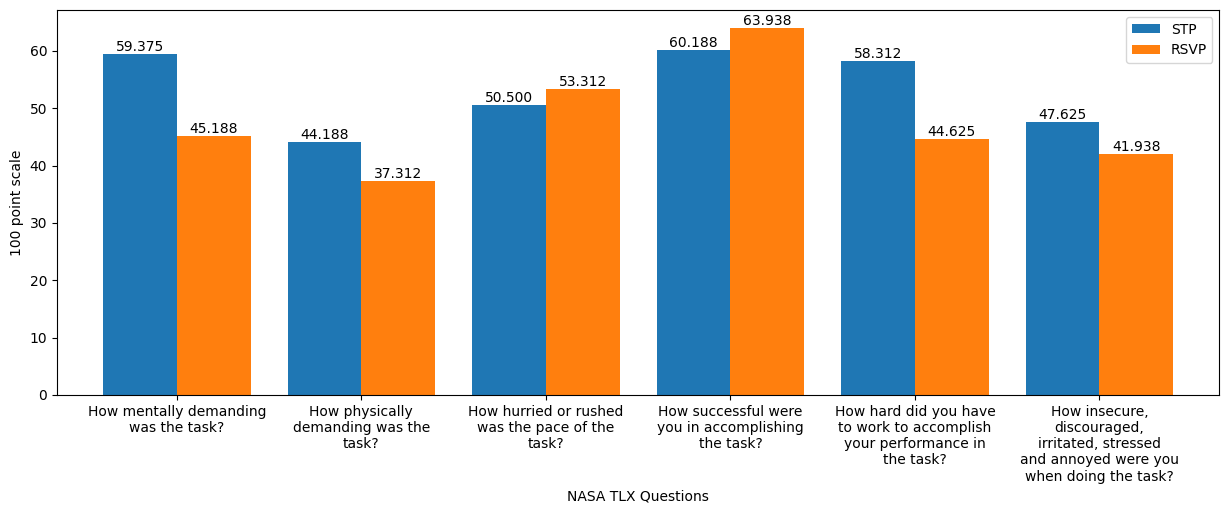

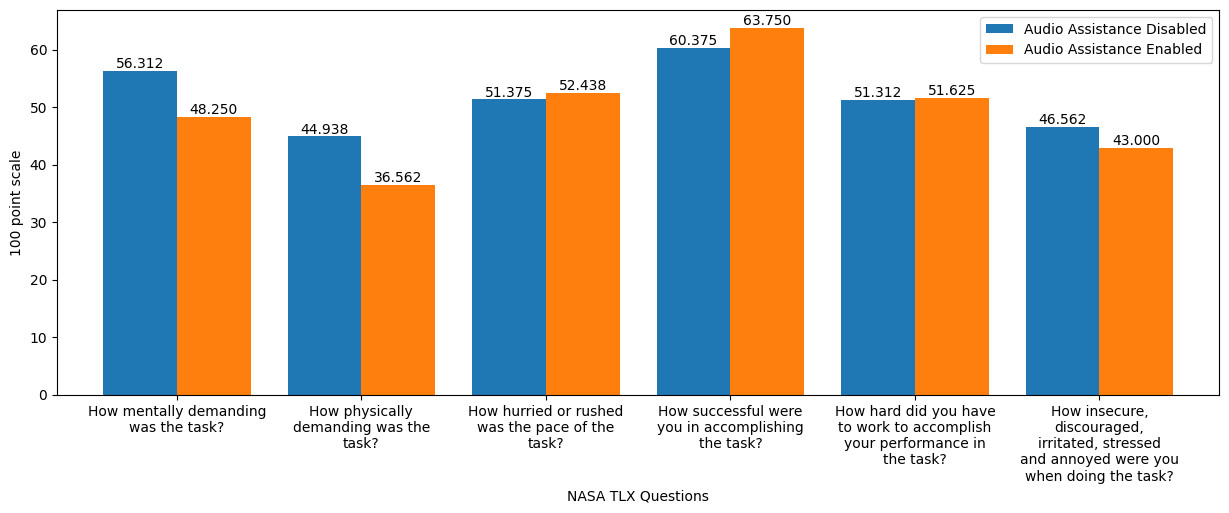

In [15]:
# Analyzing NASA-TLX form.
# Q1: Enter Participant ID
# Q2: Type of Diplay
# Q3: Text Presentation Technique
# Q4_1 How mentally demanding was the task?
# Q4_2: How physically demanding was the task?
# Q4_3: How hurried or rushed was the pace of the task?
# Q4_4: How successful were you in accomplishing the task?
# Q4_5: How hard did you have to work to accomplish your performance in the task?
# Q4_6: How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?
axis_labels = [
    "How mentally demanding was the task?",
    "How physically demanding was the task?",
    "How hurried or rushed was the pace of the task?",
    "How successful were you in accomplishing the task?",
    "How hard did you have to work to accomplish your performance in the task?",
    "How insecure, discouraged, irritated, stressed and annoyed were you when doing the task?"
]
labels = []
for label in axis_labels:
    labels.append(textwrap.fill(label, width=22,
                  break_long_words=False))

nasa_tlx_stp = nasa_tlx[nasa_tlx["Q3"] == "STP"]
nasa_tlx_rsvp = nasa_tlx[nasa_tlx["Q3"] == "RSVP"]
nasa_tlx_aae = nasa_tlx[nasa_tlx["Q2"] == "HUDAA"]
nasa_tlx_aad = nasa_tlx[nasa_tlx["Q2"] == "HUD"]

TPT_diff = np.array([
    ["Q1", np.mean(nasa_tlx_stp["Q4_1"]), np.mean(nasa_tlx_rsvp["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_stp["Q4_2"]), np.mean(nasa_tlx_rsvp["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_stp["Q4_3"]), np.mean(nasa_tlx_rsvp["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_stp["Q4_4"]), np.mean(nasa_tlx_rsvp["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_stp["Q4_5"]), np.mean(nasa_tlx_rsvp["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_stp["Q4_6"]), np.mean(nasa_tlx_rsvp["Q4_6"])],

])

AA_diff = np.array([
    ["Q1", np.mean(nasa_tlx_aad["Q4_1"]), np.mean(nasa_tlx_aae["Q4_1"])],
    ["Q2", np.mean(nasa_tlx_aad["Q4_2"]), np.mean(nasa_tlx_aae["Q4_2"])],
    ["Q3", np.mean(nasa_tlx_aad["Q4_3"]), np.mean(nasa_tlx_aae["Q4_3"])],
    ["Q4", np.mean(nasa_tlx_aad["Q4_4"]), np.mean(nasa_tlx_aae["Q4_4"])],
    ["Q5", np.mean(nasa_tlx_aad["Q4_5"]), np.mean(nasa_tlx_aae["Q4_5"])],
    ["Q6", np.mean(nasa_tlx_aad["Q4_6"]), np.mean(nasa_tlx_aae["Q4_6"])],
])

nasa_tlx_tpt_df = pd.DataFrame(TPT_diff, columns = ["Question", "STP", "RSVP"])
nasa_tlx_aa_df = pd.DataFrame(AA_diff, columns = ["Question", "AAD", "AAE"])

# Converting the column types
nasa_tlx_tpt_df["Question"] = nasa_tlx_tpt_df["Question"].astype(str)
nasa_tlx_tpt_df["STP"] = nasa_tlx_tpt_df["STP"].astype(float)
nasa_tlx_tpt_df["RSVP"] = nasa_tlx_tpt_df["RSVP"].astype(float)

nasa_tlx_aa_df["Question"] = nasa_tlx_aa_df["Question"].astype(str)
nasa_tlx_aa_df["AAD"] = nasa_tlx_aa_df["AAD"].astype(float)
nasa_tlx_aa_df["AAE"] = nasa_tlx_aa_df["AAE"].astype(float)
                                                  
# RSVP vs STP
bplot = nasa_tlx_tpt_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))

bplot.set_xticklabels(labels, rotation=0)

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot.containers:
    bplot.bar_label(p, fmt='%.3f', label_type='edge')
    
# Audio assistance disabled vs audio assistance enabled
bplot2 = nasa_tlx_aa_df.plot(x = "Question", kind = "bar", width = 0.8, rot = 0, figsize = (15, 5))
bplot2.set_xticklabels(labels, rotation=0)
bplot2.legend(["Audio Assistance Disabled", "Audio Assistance Enabled"])

plt.xlabel("NASA TLX Questions")
plt.ylabel("100 point scale")
for p in bplot2.containers:
    bplot2.bar_label(p, fmt='%.3f', label_type='edge')

,Participant_ID,TPT,Audio Assistance,Accuracy
0,P06,STP,NAA,90.000000
1,P06,STP,AA,30.000000
2,P06,RSVP,NAA,70.833333
3,P06,RSVP,AA,30.000000
4,P07,STP,NAA,100.000000
5,P07,STP,AA,80.000000
6,P07,RSVP,NAA,90.000000
7,P07,RSVP,AA,91.666667
8,P08,STP,NAA,87.500000
9,P08,STP,AA,90.000000


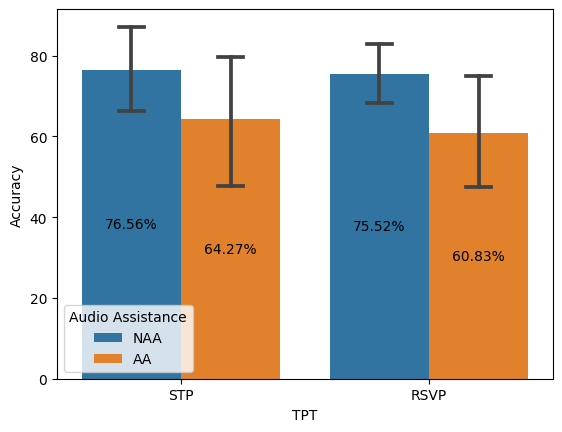

In [42]:
correct_answers = [1, 2, 3, 4, 2, 1, 3, 2, 4, 2, 4, 2, 3, 3, 4, 1, 2, 1, 3, 2, 1, 3, 4, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 2, 1, 4, 4, 4, 2]
acc_col = []
for i in range(0, comp_test_df.shape[0]):
    row = [dp for dp in comp_test_df.iloc[i].values.tolist()[4:]]
    correct = 0
    incorrect = 0
    for j in range(0, len(correct_answers)):
        if not math.isnan(row[j]):
            if row[j] == correct_answers[j]:
                correct += 1
            else:
                incorrect += 1
    acc_col.append(float(correct)/(correct+incorrect))

comp_test_acc_df = pd.DataFrame().assign(Participant_ID=comp_test_df['Q1'], AA=comp_test_df['Qa'], TPT=comp_test_df['Qb'], TF=comp_test_df['Qc'])
comp_test_acc_df['Accuracy']= acc_col
# AA = 1 If Enabled, 2 If Disabled
# TPT = 1 If STP, 2 If RSVP
# TF ranges between 1-8

# Creating a dataframe to plot the data
comp_test_refined_df = pd.DataFrame(columns=['Participant_ID', 'TPT', 'Audio Assistance', 'Accuracy'])
comp_test_refined_df["Accuracy"] = comp_test_refined_df["Accuracy"].astype(float)

for participant in comp_test_acc_df["Participant_ID"].unique():
    # Get the dataframe for the participant
    participant_df = comp_test_acc_df[comp_test_acc_df["Participant_ID"] == participant]
    
    # Get the dataframe for each of the four cases
    df_row_stp = [participant, "STP", "NAA"];
    df_row_rsvp = [participant, "RSVP", "NAA"];
    df_row_stpa = [participant, "STP", "AA"];
    df_row_rsvpa = [participant, "RSVP", "AA"];
    
    # Adding the stp NAA test value
    df_row_stp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the stp AA test value
    df_row_stpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==1)]["Accuracy"].values.mean()*100)
    # Adding the rsvp NAA test value
    df_row_rsvp.append(participant_df[(participant_df["AA"]==2) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    # Adding the rsvpa AA test value
    df_row_rsvpa.append(participant_df[(participant_df["AA"]==1) & (participant_df["TPT"]==2)]["Accuracy"].values.mean()*100)
    
    # Adding the rows in the dataframe
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_stpa
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvp
    comp_test_refined_df.loc[len(comp_test_refined_df)] = df_row_rsvpa
    
plot = sns.barplot(data=comp_test_refined_df, x="TPT", y="Accuracy", hue="Audio Assistance", capsize=0.1)
for p in plot.containers:
    plot.bar_label(p, fmt='%.2f%%', label_type='center')
display(comp_test_refined_df)